# 1. Import thư viện

Hướng dẫn này nhằm xây dựng một mạng nơ ron network để phân loại các bức ảnh thành các loại mặt hàng thời trang như áo len, giày, váy bằng tensorflow và thư viện keras. Để hiểu được các bước xây dựng mô hình bạn đọc yêu cầu phải có kiến thức cơ bản về mạng nơ ron network trong machine learning. Vì đây là một bài hướng dẫn nên sẽ sử dụng những hàm và xử lý thông dụng nhất nhất của thư viện tensorflow và keras. Keras là một thư viện bậc cao (high-level API) xây dựng và huấn luyện thuật toán machine learning dựa trên tensorflow. Do đó các hàm của nó được compile theo cú pháp tiện lợi nhằm hỗ trợ người dùng mà không cần phải coding từ các tầng bên dưới. Bạn đọc cũng sẽ dễ dàng hiểu các phần xử lý code nếu nắm vững chức năng các hàm này.

**Import các thư viện cần thiết**

In [2]:
#https://www.tensorflow.org/tutorials/keras/basic_classification
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.0


Bộ dữ liệu được sử dụng là [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) gồm 70000 bức ảnh 1 channel (grey scale) có kích thước 28x28 của 10 nhóm vật dụng thời trang như quần áo, giày dép,.... Đây là bộ dữ liệu được thay thế cho [MNIST](http://yann.lecun.com/exdb/mnist/) dataset thường được dùng trong các hướng dẫn trước đây của machine learning bởi một vài lý do chẳng hạn như:

* Kết quả MNIST đã được sử dụng quá nhiều trong các thuật toán Machine learning dẫn đến nhàm chán.
* MNIST quá dễ dàng để thu được kết quả với độ chính xác cao. Những model yếu như kNN cũng có thể đạt được mức độ chính xác > 90%. Trong khi phân loại Fashion MNIST sẽ thách thức hơn.
* Thay vì những con số khô khan và không tượng hình thì các vật dùng thời trang sẽ gợi tả hình ảnh hơn cho bộ môn computer vision.

Chúng ta sẽ chia mẫu thành 2 phần training và testing. Training chiếm 60000 bức ảnh và được sử dụng để xây dựng mô hình. Testing chiếm 10000 bức ảnh được sử dụng để đánh giá mô hình. Chúng ta có thể load bộ dữ liệu Fashion MNIST thông qua các hàm của keras.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

* train_images và train_labels lần lượt là dữ liệu (numpy array của hình ảnh) và nhãn tương ứng của tập training.
* test_images và test_labels là dữ liệu và nhãn tương ứng của tập testing.

Các nhãn đã được mã hóa thành các số nguyên và nhận giá trị từ 0 đến 9 tương ứng với tên nhóm như sau:

In [15]:
class_names = {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 
               'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
class_names

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

Kiểm tra dữ liệu

In [42]:
print('train image shape: %s, train label length: %s'%(str(train_images.shape), str(len(train_labels))))
print('test  image shape: %s, test  label length: %s'%(str(test_images.shape), str(len(test_labels))))

train image shape: (60000, 28, 28), train label length: 60000
test  image shape: (10000, 28, 28), test  label length: 10000


# 2. Tiền xử lý dữ liệu

Các bức ảnh cần được tiền xử lý trước khi đưa vào mạng nơ ron. Chúng ta có thể thấy mỗi phần tử của mảng trong 1 bức ảnh là giá trị cường độ màu sắc của 1 pixel nằm trong khoảng 0 đến 255. Giá trị cường độ càng cao thì ảnh càng sáng và càng thấp ảnh càng tối (255 là cường độ của màu trắng và 0 của màu đen).

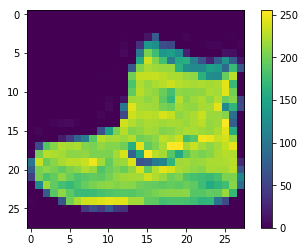

In [46]:
%matplotlib inline

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()

Chúng ta cần chuẩn hóa dữ liệu để các màu sắc này nằm trong khoảng [0, 1] bằng cách chia giá trị cường độ ảnh cho 255. Khi đó thuật toán tối ưu gradient descent sẽ hội tụ nhanh hơn với những learning_rate đủ nhỏ. 

In [48]:
train_images = train_images/255.0
test_images = test_images/255.0

Hiển thị hình ảnh của 25 bức ảnh đầu tiên.

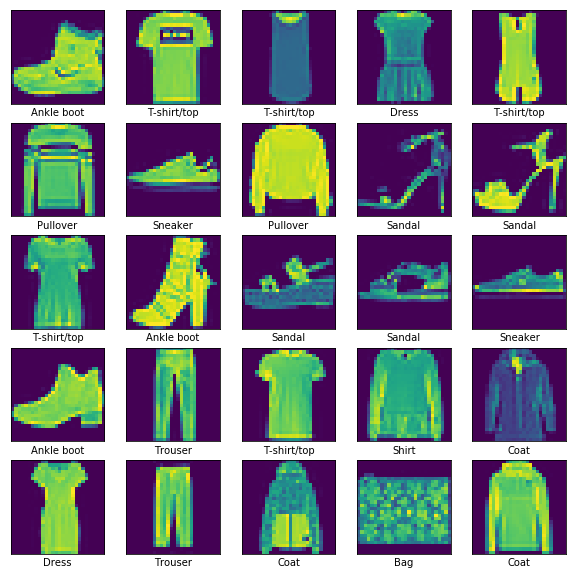

In [66]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(list(class_names.keys())[train_labels[i]])
    plt.imshow(train_images[i])

# 3. Xây dựng mô hình

**Thiết kế mạng nơ ron** 

mạng nơ ron của mô hình gồm:
1. layer 1: Một flatten layer. Layer này nhận đầu vào là một mảng 2D kích thước 28x28 nhưng chuyển thành vector 1D với kích thước bằng 28x28 = 784. Nó giống như một phép nối các dòng của ma trận liên tiếp nhau thành 1 vector theo thứ tự các dòng từ trên xuống dưới.
2. layer 2: Một dense layer kết nối mọi units của layer 1 với mọi units của layer 2 (fully connected). Số units trong layer 1 là 128. Hàm activation được sử dụng là relu có tác dụng tạo tính phi tuyến cho mạng nơ ron.
3. layer 3: Cũng là một dense layer kết nối mọi units của layer 2 với 10 units tương ứng với 10 classes của layer này. Ta sử dụng hàm softmax để tính toán xác xuất ứng với mỗi classes.

Các layer này được thiết kế nằm trong hàm `keras.Sequential()` để tạo thành mạng nơ ron có các chuỗi layers liên tục.

In [67]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

**Xây dựng hàm loss và optimizer**

Hàm loss function được lựa chọn là `sparse_categorical_crossentropy` và thuật toán được sử dụng để tối ưu hóa là `AdamOptimizer`.

In [68]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Training mô hình**

Mô hình được training với số lượng epochs = 5. Quá trình training sẽ diễn ra như sau:
1. Dữ liệu train_images lần lượt được đưa vào mô hình.
2. Quá trình feed forward và back propagation sẽ cập nhật hệ số ở mỗi layer để accuracy tăng dần.
3. Mô hình cuối cùng thu được sẽ được sử dụng để dự báo trên tập test và đo lường mức độ chính xác từ kết quả thu được.

In [ ]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 25s 409us/step - loss: 0.4969 - acc: 0.8267

**Đánh giá model trên tập test**

In [72]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test loss: {:.4f}, test accuracy: {:.4f}'.format(test_loss, test_acc))

10000/10000 [==============================] - 2s 164us/step

Tỷ lệ accuracy thu được trên tập test gần bằng với tập train cho thấy model dự báo khá tin cậy.

**Dự báo**

Dự báo xác xuất rơi vào các nhóm trên tập test.

In [74]:
predictions = model.predict(test_images)

Kết quả dự báo đối với bức ảnh đầu tiên.

In [75]:
predictions[0]

array([6.2179811e-07, 7.2959372e-10, 3.7113168e-08, 3.8896641e-08,
       6.1141061e-09, 9.0611326e-03, 6.7130406e-07, 4.8556332e-02,
       7.2653700e-07, 9.4238043e-01], dtype=float32)

Vẽ đồ thị kết quả dự báo và ảnh minh họa tương ứng cho bức ảnh đầu tiên.

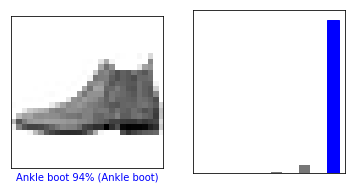

In [122]:

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(list(class_names.keys())[predicted_label],
                                100*np.max(predictions_array),
                                list(class_names.keys())[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
    
    

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Đồ thị kết quả dự báo và hình ảnh cho 25 bức ảnh đầu tiên.

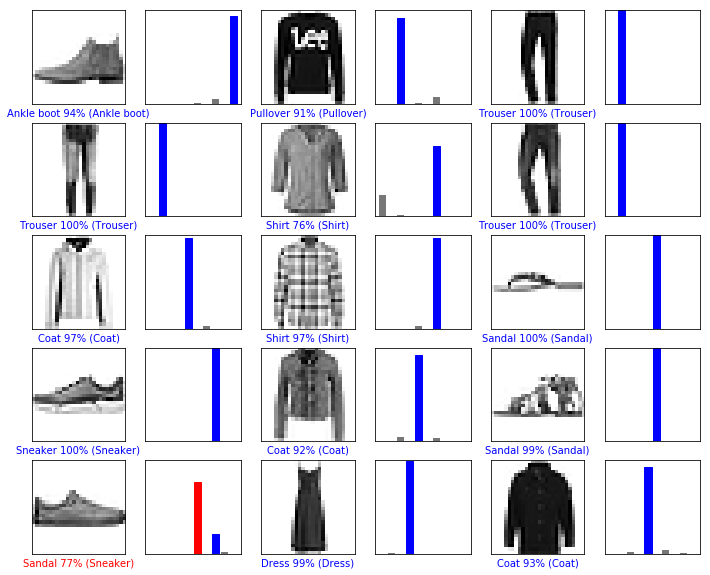

In [123]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)